## Background characterization (Figure 9)

In [1]:
# Import modules
import sys, h5py
import spimage
import numpy as np
%matplotlib inline

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
# Configuration (Experiment)
distance_back  = 2.4 #[m]
distance_front = 0.497 #[m]
pixelsize = 110e-6 #[m]
wavelength = 0.2262e-9 #[m]
scaling = (distance_back/distance_front)**2

# Cropping the front detector
c = 700

### 1. Loading data from file

In [3]:
filename_xray   = "../meta/background_beamline_stats.h5"
filename_buffer = "../meta/background_buffer_stats.h5"
filename_mask_back  = '../meta/back/masks/back_bad-pixels_assembled.h5'
filename_mask_front = '../meta/front/masks/front_mask.h5'

In [4]:
with h5py.File(filename_xray, 'r') as f:
    xray_back_mean  = f['back/mean'][:]
    xray_back_var   = f['back/std'][:]**2
    xray_front_mean = np.rot90(f['front/mean'][:], k=2)
    xray_front_var  = np.rot90(f['front/std'][:], k=2)**2
    nframes = f['nframes'][...]
print "Loaded X-ray background stats based on %d frames" %nframes

Loaded X-ray background stats based on 15127 frames


In [5]:
with h5py.File(filename_buffer, 'r') as f:
    buffer_back_mean  = f['back/mean'][:]
    buffer_back_var   = f['back/std'][:]**2
    buffer_front_mean = np.rot90(f['front/mean'][:], k=2)
    buffer_front_var  = np.rot90(f['front/std'][:], k=2)**2
    nframes    = f['nframes'][...]
print "Loaded buffer background stats based on %d frames" %nframes

Loaded buffer background stats based on 11847 frames


### 2. Index of dispersion

In [6]:
# Mark pixels with zero mean as NAN (to avoid division-by-zero errors)
xray_back_mean[(xray_back_mean == 0)] = np.nan
xray_front_mean[(xray_front_mean == 0)] = np.nan

# Calculate index of dispersion (variance over mean)
xray_back_dispersion  = xray_back_var  / xray_back_mean
xray_front_dispersion = xray_front_var / xray_front_mean

### 3. Define new masks

In [7]:
# Load previous masks (bad pixels)
with h5py.File(filename_mask_back, 'r') as f:
    bmask = f['data/data'][:]
with h5py.File(filename_mask_front, 'r') as f:
    fmask = np.rot90(f['data/data'][:], k=-2)

# Combine existing masks with mask based on in index of dispersion (mask out areas not following Poisson statistics)
bvalid = ~np.isnan(xray_back_dispersion)
fvalid = ~np.isnan(xray_front_dispersion)
bmask &= bvalid
fmask &= fvalid
bmask[bvalid] &= ((xray_back_dispersion[bvalid] < 1.01) & (xray_back_dispersion[bvalid] > 0.99))
fmask[fvalid] &= ((xray_front_dispersion[fvalid] < 1.01) & (xray_front_dispersion[fvalid] > 0.99))

# Save new masks to file
with h5py.File("../meta/back/masks/back_mask_poisson.h5", 'w') as f:
    f['data/data'] = bmask
with h5py.File("../meta/front/masks/front_mask_poisson.h5", 'w') as f:
    f['data/data'] = fmask

### 4. Radial average

In [8]:
# Center of front detector
cx_back=(xray_back_mean.shape[1]-1)/2.0-16
cy_back=(xray_back_mean.shape[0]-1)/2.0-36

# Center of front detector
cx_front=(xray_front_mean.shape[1]-1)/2.0-3
cy_front=(xray_front_mean.shape[0]-1)/2.0-20

In [9]:
# Convert index to q (in nm)
x_to_q = lambda x, d: (2*np.sin(np.arctan2(x*pixelsize, d)/2.)) / wavelength / 1e9

In [10]:
# Radial average of X-ray background (back)
xray_back_centers, xray_back_mean_radial = spimage.radialMeanImage(xray_back_mean, msk=bmask, output_r=True)
xray_back_mean_radial *= (distance_back/distance_front)**2
xray_back_qr = x_to_q(xray_back_centers, distance_back)

# Radial average of buffer background (back)
buffer_back_centers, buffer_back_mean_radial = spimage.radialMeanImage(buffer_back_mean, msk=bmask, output_r=True)
buffer_back_mean_radial *= (distance_back/distance_front)**2
buffer_back_qr = x_to_q(buffer_back_centers, distance_back)

# Radial average of X-ray background (front)
xray_front_centers, xray_front_mean_radial = spimage.radialMeanImage(xray_front_mean, msk=fmask, cx=cx_front,cy=cy_front, output_r=True)
xray_front_qr = x_to_q(xray_front_centers, distance_front)

# Radial average of buffer background (front)
buffer_front_centers, buffer_front_mean_radial = spimage.radialMeanImage(buffer_front_mean, msk=fmask, cx=cx_front,cy=cy_front, output_r=True)
buffer_front_qr = x_to_q(buffer_front_centers, distance_front)

In [11]:
# Prepare radial averages for plotting
x1 = xray_back_qr[::8]
x2 = xray_front_qr[::8]
x3 = buffer_back_qr[::8]
x4 = buffer_front_qr[::8]
y1 = xray_back_mean_radial[::8]
y2 = xray_front_mean_radial[::8]
y3 = buffer_back_mean_radial[::8]
y4 = buffer_front_mean_radial[::8]

# Prepare images for plotting
im0 = xray_back_var
im1 = xray_front_var[c-48:-c+6,c-34:-c+20]
im2 = xray_back_mean
im3 = xray_front_mean[c-48:-c+6,c-34:-c+20]
im4 = xray_back_dispersion
im5 = xray_front_dispersion[c-48:-c+6,c-34:-c+20]

### 5. Plotting

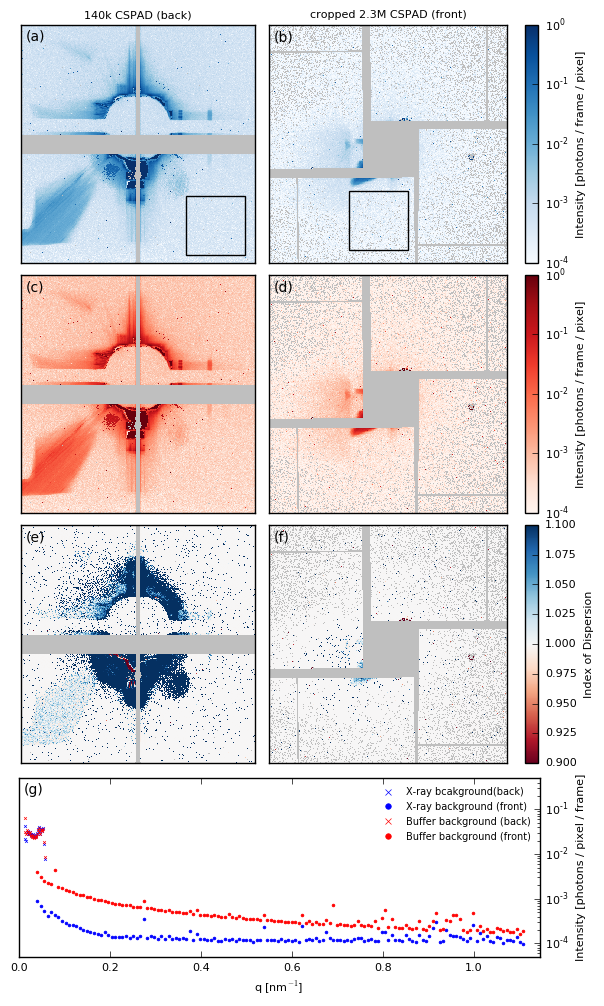

In [12]:
plot = plotting.Plot(rows=3, cols=2, fontsize=8, colorbar=False, legend=True, legend_frameon=False, axes_visible=False, save_pdf=True)
plot.add_axes((2,2),0.1,1, padx=.01)
plot.add_axes((2,1),0.1,1, padx=.01)
plot.add_axes((2,0),0.1,1, padx=.01)
plot.add_axes((0,0),2.13,1,   pady=-.21, hfrac=0.75)
plot.title_label = ['140k CSPAD (back)', 'cropped 2.3M CSPAD (front)'] + 9*['']
plot.xlabel = 9*[''] + [r'q [nm$^{-1}$]']
plot.ylabel = 9*[''] + [r'Intensity [photons / pixel / frame]']
plot.colorbar_label = r'Intensity [photons / frame / pixel]'
plot.plotting_a_map(0, im0[10:,:-17], mask=(im0!=0)[10:,:-17],  
                    vmin=1e-4, vmax=1, bad='0.75', log=True, cmap='Blues', interpolation='nearest',
                    colorbar=True, cax=plot.axes[6])
plot.plotting_a_map(1, im1, mask=(im1!=0), 
                    vmin=1e-4, vmax=1, bad='0.75', log=True, cmap='Blues', interpolation='nearest')
plot.plotting_a_map(2, im2[10:,:-17], mask=(im2!=0)[10:,:-17],  
                    vmin=1e-4, vmax=1, bad='0.75', log=True, cmap='Reds', interpolation='nearest',
                   colorbar=True, cax=plot.axes[7])
plot.plotting_a_map(3, im3, mask=(im3!=0), 
                    vmin=1e-4, vmax=1, bad='0.75', log=True, cmap='Reds', interpolation='nearest')
plot.colorbar_label = r'Index of Dispersion'
plot.plotting_a_map(4, im4[10:,:-17], mask=(im4!=0)[10:,:-17],  
                    vmin=0.9, vmax=1.1, bad='0.75', log=False, cmap='RdBu', interpolation='nearest',
                    colorbar=True, cax=plot.axes[8])
plot.plotting_a_map(5, im5, mask=(im5!=0), 
                    vmin=0.9, vmax=1.1, bad='0.75', log=False, cmap='RdBu', interpolation='nearest')
plot.set_axes_layout(plot.axes[9], visible=True)
plot.plotting_traces(9,
                     [x1, x2, x3, x4], [y1, y2, y3, y4],
                     ['X-ray bcakground(back)', 'X-ray background (front)', 'Buffer background (back)', 'Buffer background (front)'], 
                     linestyles=['-', '-', '-', '-'],                                                                                                           
                     linewidths=[0,0,0,0], xlim=[0,x_to_q(1200., distance_front)], ylim=[5e-5,5e-1],                                                                                                    
                     markersize=2, markers=['x', 'o', 'x', 'o',],                                                                                                 
                     mecs=['b', 'b', 'r', 'r'], mfcs=['b', 'b', 'r', 'r'],                                                                            
                     colors=['b', 'b', 'r', 'r'], alphas=[1,1,1,1,1],                                                                                                  
                     logx=False, logy=True)
plot.axes[9].yaxis.set_label_position('right')
plot.axes[9].tick_params(axis='y', which='both', left='off', right='on', labelleft='off', labelright='on')
plot.plotting_a_rectangle(0, 280,290, 100,100, edgecolor='k')
plot.plotting_a_rectangle(1, 134,278, 100,100, edgecolor='k')
plot.axes[0].text(8,8, '(a)', va='top', ha='left', fontsize=10, color='k')
plot.axes[1].text(8,8, '(b)', va='top', ha='left', fontsize=10, color='k')
plot.axes[2].text(8,8, '(c)', va='top', ha='left', fontsize=10, color='k')
plot.axes[3].text(8,8, '(d)', va='top', ha='left', fontsize=10, color='k')
plot.axes[4].text(8,8, '(e)', va='top', ha='left', fontsize=10, color='k')
plot.axes[5].text(8,8, '(f)', va='top', ha='left', fontsize=10, color='k')
plot.axes[9].text(0.01,0.4, '(g)', va='top', ha='left', fontsize=10, color='k')

#plot.save('/Users/benedikt/phd-project/documentation/manuscripts/omrv-paper/manuscript/figures/fig_background.pdf')
plot.show()

**Figure 9.**
Per-pixel variance and mean of photon counts on the back (a,c) and the center part of the front (b,d) detector after aperture alignment                                   
based on $15\,127$ X-ray background (no injection) frames.                                                                                                                         
The median photon count inside the black boxes were $4.63\cdot10^{-4}$ (back) and $1.98\cdot10^{-4}$ (front).                                                                      
The per-pixel index of dispersion (ratio of variance over mean) for the back (e) and the front (f) marks areas that follow Poisson statistics (ratio of 1).                        
Masked areas (no photons detected, bad pixels) are colored in gray for (a-f).                                                                                                      
Radial average of the mean photon counts from the X-ray background (c,d) in comparison to mean photon counts from buffer background.                                               
Intensity values from the back detector are up-scaled according to given detector distances (relative to interaction point). 

### 6. More analysis

In [13]:
print "Average photon count inside black rectangle (back):  %e " %np.median(im0[290:390,280:380])
print "Average photon count inside black rectangle (front): %e " %np.median(im1[278:378,134:234])
print "Average photon count inside black rectangle (back):  %e " %np.nanmedian(im2[290:390,280:380])
print "Average photon count inside black rectangle (front): %e " %np.nanmedian(im3[278:378,134:234])

Average photon count inside black rectangle (back):  4.625346e-04 
Average photon count inside black rectangle (front): 1.982816e-04 
Average photon count inside black rectangle (back):  4.627487e-04 
Average photon count inside black rectangle (front): 1.983209e-04 


In [14]:
# Plotting a histogram of mean inside black box (back)
plotting.plt.hist(back_mean[290:390,280:380].flat, range=(1e-4, 1e-3), bins=14)
plotting.plt.show()

NameError: name 'back_mean' is not defined

In [ ]:
# Plotting a histogram of mean inside black box (front)
plotting.plt.hist(back_var[290:390,280:380].flat, range=(1e-4, 1e-3), bins=14)
plotting.plt.show()

In [ ]:
# Plotting a histogram of dispersion (back)
plotting.plt.hist((xray_back_dispersion[bmask]).flat, range=(0.99, 1.01), bins=200)
plotting.plt.show()

In [ ]:
# Plotting a histogram of dispersion (front)
plotting.plt.hist((xray_front_dispersion[fmask]).flat, range=(0.99, 1.01), bins=200)
plotting.plt.show()